In [159]:
#analysis

import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.init as weight_init

import numpy as np
import numpy.ma as ma
import pickle
import re
import time
from tqdm.notebook import tqdm

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.cm as cmx
import sklearn
import sklearn.decomposition

import os
current_dir = os.path.dirname(os.path.realpath('__file__'))
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


import os, sys
os.path.abspath(os.getcwd())
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT")
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\PsychRNN")

from psychrnn.backend.rnn import RNN
from psychrnn.tasks.task import Task

from utils import *

In [255]:
#load model
#list experiment folders
import glob
exp_list = glob.glob(current_dir+"\\experiments\\exp_16*")
exp_list = sorted(exp_list, key = lambda x: int(x[-10:]))
exp_path = exp_list[-1]
idx = exp_path[-10:]

with open(exp_path + '/train_params.pickle', 'rb') as handle:
    train_params = pickle.load(handle)
with open(exp_path + '/network_params.pickle', 'rb') as handle:
    network_params = pickle.load(handle)
    
exp_path = 'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\\\sgd_mse_exp_1655141227'
# try:
with open(exp_path + '\\train_params.pickle', 'rb') as handle:
    train_params = pickle.load(handle)
with open(exp_path + '\\network_params.pickle', 'rb') as handle:
    network_params = pickle.load(handle)
# except:
#     with open(exp_path + '\\network_training_params.pickle', 'rb') as handle:
#         training_kwargs = pickle.load(handle)
idx = int(re.search(r'\d+', exp_path).group())
# rnn_model.load_state_dict(torch.load(train_params['save_weights_path']+'\\weights%s.pth'%idx))

rnn_model = RNNModel(network_params['N_in'], network_params['N_out'], network_params['N_rec'], n_layers=1, transform_function='relu').to(device)
def load_model(model, train_params, network_params):
    try:
        model.load_state_dict(torch.load(train_params['save_weights_path']+'\\weights%s.pth'%network_params['idx']))
    except:
        weight_list = glob.glob(train_params['training_weights_path']+'\\*')
        file = weight_list[0]
        idx = int(re.search(r'\d+', file).group())
        coh_epoch_dict = {}
        for file in weight_list:
            coh = float(file.split("coh",1)[1].split("_",1)[0])
            epoch = int(file.split("epoch",1)[1].split("_",1)[0])
            try:
                coh_epoch_dict[coh].append(epoch)
            except:
                coh_epoch_dict[coh] = [epoch]
        coherence = sorted(list(coh_epoch_dict.keys()))[0]
        epoch = sorted(coh_epoch_dict[coherence])[-1]
        model.load_state_dict(torch.load(train_params['training_weights_path'] + '/weights_coh%s_epoch%s_%s.pth'%(coherence, epoch, network_params['idx'])))
    return model
# file = train_params['save_weights_path']+'\\weights%s.pth'%network_params['idx']
rnn_model = load_model(rnn_model, train_params, network_params)
rnn_model.eval();

Losses

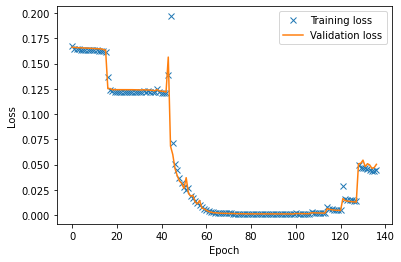

In [256]:
losses = np.loadtxt(train_params['save_weights_path'] + '/training_loss.txt', delimiter=',')
plt.plot(losses, 'x', label="Training loss")
val_losses = np.loadtxt(train_params['save_weights_path'] + '/validation_loss.txt', delimiter=',')
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.ylim([0, max([losses[0], val_losses[0]])])
# plt.ylim([0, 1])
plt.legend()
# plt.savefig(train_params['figures_path'] + '/losses.pdf')
plt.savefig(train_params['figures_path'] + '/losses_opt'+train_params['optimizer']+'lr'+str(train_params['learning_rate'])+'.pdf')

In [257]:
sgd_exps = "C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\sgd_exps"
makedirs(sgd_exps)

In [258]:
exp_list = glob.glob(current_dir+"\\experiments\\exp_16*")
exp_list = sorted(exp_list, key = lambda x: int(x[-10:]))
for exp_path in exp_list:
    try:
        with open(exp_path + '\\train_params.pickle', 'rb') as handle:
            train_params = pickle.load(handle)
        with open(exp_path + '\\network_params.pickle', 'rb') as handle:
            network_params = pickle.load(handle)
    except:
        with open(exp_path + '\\network_training_params.pickle', 'rb') as handle:
            training_kwargs = pickle.load(handle)
    try:
        rnn_model = load_model(rnn_model, train_params, network_params)
        rnn_model.eval();
    except:
        continue
    # plot_losses(epoch_losses, epoch_val_losses, train_params)
    
    losses = np.loadtxt(train_params['save_weights_path'] + '/training_loss.txt', delimiter=',')
    fig = plt.figure(figsize=(6,6))
    plt.plot(losses, 'x', label="Training loss")
    try:
        val_losses = np.loadtxt(train_params['save_weights_path'] + '/validation_loss.txt', delimiter=',')
        plt.plot(val_losses, label="Validation loss")
    except:
        0
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(sgd_exps + '/losses_'+'lossfunc'+train_params['loss_function']+'_opt'+train_params['optimizer']+'_lr'+str(train_params['learning_rate'])+'_sched'+str(train_params['scheduler'])+'_%s.pdf'%network_params['idx'])
    plt.close()

Weights

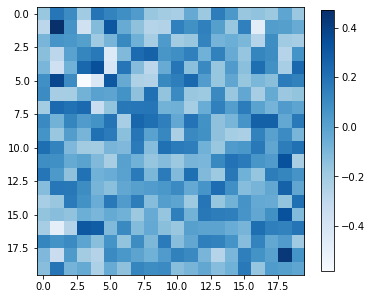

In [259]:
#recurrence matrix
W_hh = rnn_model.state_dict()['rnn.weight_hh_l0'] #['rnn.weight_ih_l0']

fig, (ax) = plt.subplots(figsize=(6, 6), ncols=1)
im = ax.imshow(W_hh, cmap='Blues', interpolation='none')
fig.colorbar(im, ax=ax, location='right', anchor=(0, 0.5), shrink=0.8);

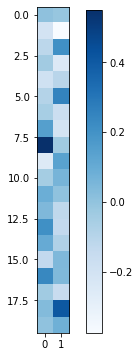

In [260]:
#input matrix
W_ih = rnn_model.state_dict()['rnn.weight_ih_l0'] 

fig, (ax) = plt.subplots(figsize=(6, 6), ncols=1)
im = ax.imshow(W_ih, cmap='Blues', interpolation='none')
fig.colorbar(im, ax=ax, location='right', anchor=(0, 0.), shrink=0.99)

In [261]:
try:
    train_params['figures_path']
except:
    train_params['figures_path'] = train_params['save_weights_path'] + '\\figures'
    makedirs(train_params['figures_path'])
    
train_params['figures_path']

'C:\\Users\\abel_\\Documents\\Rotations\\CIT/experiments/exp_1655139365//figures/'

PCA

In [262]:
#PCA for one coherence data
coherence = 0.5 #easy
# data_size = 10000
# pd = PerceptualDiscrimination(dt=10, tau=100, T=2000,
#                               N_batch=data_size, coherence=coherence)
# x, y, output_mask, trial_params = pd.get_trial_batch() #generate self.N_batch trials
# data_set = [x, y, output_mask, trial_params]
# with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\data_coh%s.pickle"%coherence, 'wb') as handle:
#     pickle.dump(data_set, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\data_coh%s.pickle"%coherence, 'rb') as handle:
    data_set = pickle.load(handle)
x, y, output_mask, trial_params = data_set

In [263]:
# x, y, output_mask, _ = pd.get_trial_batch() #generate self.N_batch trials
# inputs = torch.tensor(x, dtype=torch.float)
# yhat, hidden = rnn_model(inputs)
# yhat_np = yhat.detach().numpy()
# print("Accuracy:", pd.accuracy_function(y, yhat_np, output_mask))

In [264]:
#initialize hidden states
inputs = torch.tensor(x, dtype=torch.float)
hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
hidden_states = hidden_states.detach().numpy()
hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))

In [265]:
n_components = 10
pca = sklearn.decomposition.PCA(n_components=n_components)
X_new = pca.fit_transform(hidden_states) # shape: (n_samples, n_features)

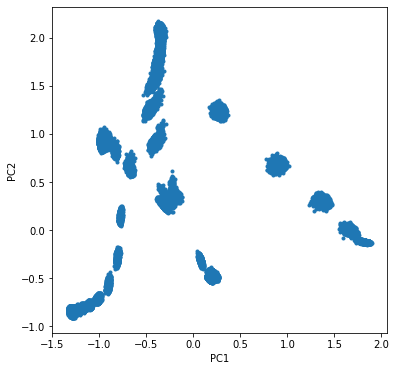

In [266]:
plt.figure(figsize=(6,6))
plt.plot(X_new[:,0], X_new[:,1], '.')
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.savefig(train_params['figures_path'] + '\\pca_coh%s_ncomp%s.pdf'%(coherence, 2))

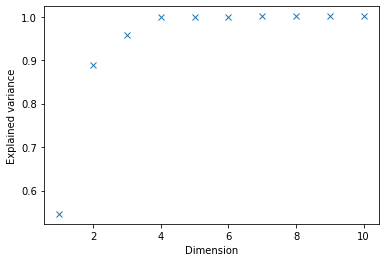

In [267]:
# pca.get_covariance()
plt.plot(range(1, n_components+1), pca.explained_variance_ratio_.cumsum(), 'x')
plt.xlabel("Dimension")
plt.ylabel("Explained variance");
plt.savefig(train_params['figures_path'] + '\\varexpl_coh%s.pdf'%(coherence))

In [268]:
#PCA for various coherences data
coherence_list = np.linspace(.0, 0.5, 101)
# data_size = 10000
# pd = PerceptualDiscrimination(dt=10, tau=100, T=2000,
#                               N_batch=data_size, coherence=None,
#                               coherence_list = coherence_list)
# x, y, output_mask, trial_params = pd.get_trial_batch() #generate self.N_batch trials
# data_set = [x, y, output_mask, trial_params]
# with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\data_cohs_0_0.5.pickle", 'wb') as handle:
#     pickle.dump(data_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\data_cohs_0_0.5.pickle", 'rb') as handle:
    data_set = pickle.load(handle)
x, y, output_mask, trial_params = data_set
inputs = torch.tensor(x, dtype=torch.float)

In [428]:
#initialize hidden states
hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
hidden_states = hidden_states.detach().numpy()
flat_hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))

In [429]:
n_components = 10
pca = sklearn.decomposition.PCA(n_components=n_components)
X_new = pca.fit_transform(flat_hidden_states)

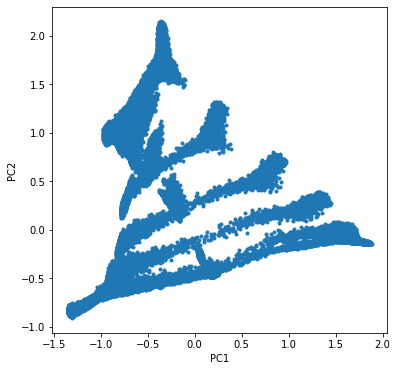

In [282]:
plt.figure(figsize=(6,6))
plt.plot(X_new[:,0], X_new[:,1], '.')
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.savefig(train_params['figures_path'] + '\\pca_cohlist_ncomp%s.pdf'%(2))

In [424]:
coherence_array = np.array([[trial_params[i]['coherence']]*200 for i in range(len(trial_params))])
flat_coherence_array = coherence_array.reshape(-1)

cmap = cm = plt.get_cmap('viridis') 
cNorm  = colors.Normalize(vmin=np.min(flat_coherence_array), vmax=np.max(flat_coherence_array))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
flat_coherence_array.shape

(2000000,)

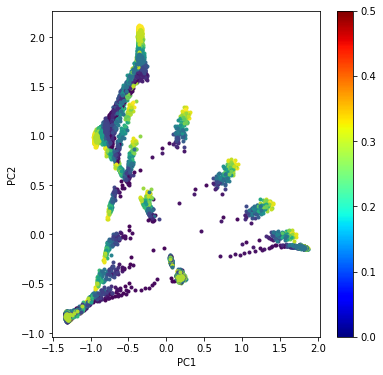

In [392]:
plt.figure(figsize=(6,6))
# for i in range(X_new.shape[0]):
for i in range(50000):
    plt.plot(X_new[i,0], X_new[i,1], '.', color=scalarMap.to_rgba(flat_coherence_array[i]))
plt.xlabel("PC1")
plt.ylabel("PC2");
s_m = matplotlib.cm.ScalarMappable(cmap=cmap, norm=cNorm)
plt.colorbar(s_m)
# s_m.ax.set_title('Your Label',fontsize=8)
plt.savefig(train_params['figures_path'] + '\\pca_cohlist_cohcolor_ncomp_%s.pdf'%(2))

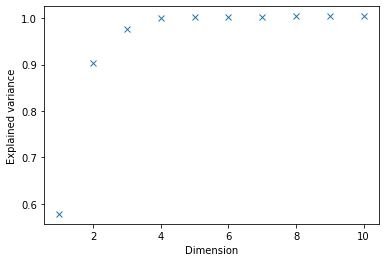

In [399]:
# pca.get_covariance()
plt.plot(range(1, n_components+1), pca.explained_variance_ratio_.cumsum(), 'x')
plt.xlabel("Dimension")
plt.ylabel("Explained variance");
plt.savefig(train_params['figures_path'] + '\\varexpl_cohlist.pdf')

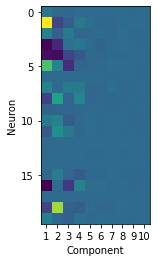

In [415]:
loading_matrix = pca.components_.T * np.sqrt(pca.explained_variance_)
plt.imshow(loading_matrix)
plt.xticks(range(0,n_components),range(1,n_components+1))
plt.yticks(range(0,network_params['N_rec'], 5))
plt.xlabel("Component")
plt.ylabel("Neuron")
plt.savefig(train_params['figures_path'] + '\\loadingmat_cohlist.pdf')

In [427]:
np.where(coherence_array==0.3)

(array([  58,   58,   58, ..., 9916, 9916, 9916], dtype=int64),
 array([  0,   1,   2, ..., 197, 198, 199], dtype=int64))

In [475]:

# np.apply_along_axis(pca.transform, axis=0, arr=hidden_states[0,:,:])
cmap = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=int(train_params['T']))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

In [478]:
# for i in range():
for t in range(200):
    plt.plot(pca.transform(hidden_states[0,:,:])[t,0], pca.transform(hidden_states[0,:,:])[t,1], 'x', color=scalarMap.to_rgba(t*10))
s_m = matplotlib.cm.ScalarMappable(cmap=cmap, norm=cNorm)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(s_m)


In [487]:
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_components)]

initial_feature_names = [i for i in range(network_params['N_rec'])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_components)]
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_components)}
df = pd.DataFrame(dic.items())
df

0   1
0  PC0   1
1  PC1  18
2  PC2   5
3  PC3   8
4  PC4   8
5  PC5   3
6  PC6   2
7  PC7   2
8  PC8  10
9  PC9   7

In [326]:
hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
hidden_states = hidden_states.detach().numpy()
hidden_states.shape

(10000, 200, 20)

In [327]:
np.sum(hidden_states, axis=(0,1)).shape

In [328]:
dead_neurons = np.where(np.sum(hidden_states, axis=(0,1))==0)

In [329]:
dead_neurons

(array([14, 17], dtype=int64),)

In [372]:
# rnn_model.rnn.all_weights[0]

In [373]:
# with torch.no_grad():
#     for weights in rnn_model.rnn.all_weights[0]:
#         print(weights.shape)

In [374]:
# neuron_idx = 0
# rnn_model.fc.weight[:,neuron_idx]
# rnn_model.fc.weight.shape

In [365]:
rnn_model.fc.bias[neuron_idx]

train_params['weight_reinitialization_variance'] = 0.001

In [382]:
# torch.normal(0, train_params['weight_reinitialization_variance'], (1))
torch.normal(0, train_params['weight_reinitialization_variance'], size=(1,1))

tensor([[0.0009]])

In [381]:
torch.normal(2, 3, size=(1,1))

tensor([[2.4410]])